In [1]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image
import shutil
import random
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from torchvision import transforms, datasets
import torchvision

from dsd import DSDTraining
from utils import plot_wb, set_all_seed
from squeezenet import SqueezeNet

### Load Dataset

In [2]:
def load_cifar10(BATCH_SIZE=64):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Clear downloading message.
    clear_output()

    # Split dataset into training set and validation set.
    train_dataset, val_dataset = random_split(train_dataset, [45000, 5000])

    print("Image Shape: {}".format(train_dataset[0][0].shape), end='\n\n')
    print("Training Set:   {} samples".format(len(train_dataset)))
    print("Validation Set:   {} samples".format(len(val_dataset)))
    print("Test Set:       {} samples".format(len(test_dataset)))

    # Create iterators.
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    # Delete the data/ folder.
    shutil.rmtree('./data')

    return train_loader, val_loader, test_loader

In [3]:
train_loader, val_loader, test_loader = load_cifar10()

Image Shape: torch.Size([3, 32, 32])

Training Set:   45000 samples
Validation Set:   5000 samples
Test Set:       10000 samples


### Model Training

#### Load Model

In [4]:
model = SqueezeNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
dsd_model = DSDTraining(model, sparsity=0.3)
summary(dsd_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
       FireModule-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

#### Define Loss and Optimizer

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(dsd_model.parameters(), lr=0.001, momentum=0.9, nesterov=True)

#### Train Model

In [6]:
def train_dsd(dsd_model, EPOCH_DENSE1, EPOCH_SPARSE, EPOCH_DENSE2, NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES):
    EPOCHS = EPOCH_DENSE1 + EPOCH_SPARSE + EPOCH_DENSE2
    train_costs, val_costs = [], []

    #Training phase.
    for epoch in range(EPOCHS):

        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Train Acc':^12} | {'Val Loss':^10} | {'Val Acc':^10} | {'Elapsed':^9}")
        print("-"*85)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # DSD
        if (epoch >= EPOCH_DENSE1 and epoch < EPOCH_DENSE1 + EPOCH_SPARSE):
            dsd_model.train_on_sparse = True
        else:
            dsd_model.train_on_sparse = False

        if dsd_model.train_on_sparse:
            dsd_model.update_masks()
        
        # Training
        train_loss, correct_train = 0, 0
        batch_loss, correct_batch, batch_counts = 0, 0, 0

        if device == "cuda":
            dsd_model.train().cuda()

        for step, (inputs, labels) in enumerate(train_loader):

            # Load data to GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients.
            optimizer.zero_grad()

            # Forward pass.
            prediction = dsd_model(inputs)

            # Compute the loss.
            loss = criterion(prediction, labels)

            # Backward pass.
            loss.backward()

            # Sparse-phase
            if dsd_model.train_on_sparse:
                for (w, b), (mask_w, mask_b) in zip(dsd_model.parameters(), dsd_model.masks):
                    # Values
                    w.data[mask_w] = 0
                    b.data[mask_b] = 0
                    # Grad
                    w.grad.data[mask_w] = 0
                    b.grad.data[mask_b] = 0

            # Optimize.
            optimizer.step()

            # Compute training accuracy.
            _, predicted = torch.max(prediction.data, 1)
            correct_train += (predicted == labels).sum().item()
            correct_batch += (predicted == labels).sum().item()

            # Compute batch loss.
            batch_loss += (loss.data.item() * inputs.shape[0])
            train_loss += (loss.data.item() * inputs.shape[0])

            # Print the loss values and time elapsed for every 20 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_loader) - 1):

                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {correct_batch / batch_counts:^12.6f} | {'-':^10} | {'-':^10} |  {time_elapsed:^9.2f}")
                batch_loss, correct_batch, batch_counts = 0, 0, 0
                t0_batch = time.time()

            batch_counts += inputs.shape[0]

        train_loss /= NB_TRAIN_EXAMPLES
        train_costs.append(train_loss)
        train_acc =  correct_train / NB_TRAIN_EXAMPLES

        print("-"*85)

        # Validation
        val_loss = 0
        correct_val = 0

        if device == "cuda":
            dsd_model.eval().cuda()

        with torch.no_grad():
            for inputs, labels in val_loader:
                # Load data to GPU.
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass.
                prediction = dsd_model(inputs)

                # Compute the loss.
                loss = criterion(prediction, labels)

                # Compute training accuracy.
                _, predicted = torch.max(prediction.data, 1)
                correct_val += (predicted == labels).sum().item()

                # Compute batch loss.
                val_loss += (loss.data.item() * inputs.shape[0])

            val_loss /= NB_VAL_EXAMPLES
            val_costs.append(val_loss)
            val_acc =  correct_val / NB_VAL_EXAMPLES

        time_elapsed = time.time() - t0_epoch

        info = "[Epoch {}/{}]: train_on_sparse = {} | train-loss = {:0.6f} | train-acc = {:0.6f} | val-loss = {:0.6f} | val-acc = {:0.6f} | time_elapsed = {:0.2f}"
        print(info.format(epoch+1, EPOCHS, dsd_model.train_on_sparse, train_loss, train_acc, val_loss, val_acc, time_elapsed))

        # Save plots.
        if (epoch + 1 == EPOCH_DENSE1):
            plot_wb(dsd_model, "dense1.png")
        elif (epoch + 1 == EPOCH_DENSE1 + EPOCH_SPARSE):
            plot_wb(dsd_model, "sparse.png")
        elif (epoch + 1 == EPOCHS):
            plot_wb(dsd_model, "dense2.png")

    return train_costs, val_costs

In [7]:
EPOCH_DENSE1 = 5
EPOCH_SPARSE = 3
EPOCH_DENSE2 = 5
NB_TRAIN_EXAMPLES = len(train_loader.dataset)
NB_VAL_EXAMPLES = len(val_loader.dataset)

set_all_seed(42)
train_costs, val_costs = train_dsd(dsd_model, 
                                   EPOCH_DENSE1, 
                                   EPOCH_SPARSE, 
                                   EPOCH_DENSE2, 
                                   NB_TRAIN_EXAMPLES, 
                                   NB_VAL_EXAMPLES)

 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   1    |   100   |   2.325837   |   0.097187   |     -      |     -      |    2.37   
   1    |   200   |   2.302793   |   0.097187   |     -      |     -      |    2.34   
   1    |   300   |   2.302644   |   0.099062   |     -      |     -      |    2.33   
   1    |   400   |   2.302731   |   0.096562   |     -      |     -      |    2.39   
   1    |   500   |   2.302469   |   0.100000   |     -      |     -      |    2.36   
   1    |   600   |   2.302567   |   0.105625   |     -      |     -      |    2.33   
   1    |   700   |   2.302560   |   0.100156   |     -      |     -      |    2.32   
   1    |   703   |   1.631607   |   0.041667   |     -      |     -      |    0.07   
-------------------------------------------------------------------------------------
[Epoch 1/13]: train_on_sparse = False | train-

   8    |   500   |   2.302582   |   0.107031   |     -      |     -      |    2.27   
   8    |   600   |   2.302611   |   0.104375   |     -      |     -      |    2.28   
   8    |   700   |   2.302572   |   0.102031   |     -      |     -      |    2.30   
   8    |   703   |   1.631068   |   0.083333   |     -      |     -      |    0.07   
-------------------------------------------------------------------------------------
[Epoch 8/13]: train_on_sparse = True | train-loss = 2.302587 | train-acc = 0.101111 | val-loss = 2.302527 | val-acc = 0.104000 | time_elapsed = 17.43
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   9    |   100   |   2.325619   |   0.101562   |     -      |     -      |    2.31   
   9    |   200   |   2.302515   |   0.103438   |     -      |     -      |    2.25   
   9    |   300   |   2.302504   |   0.109063   |     -      |     -  

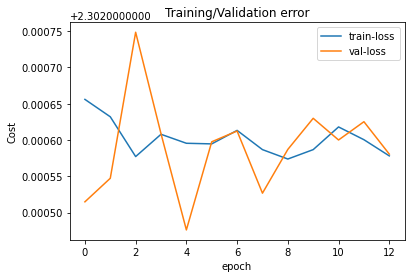

In [8]:
plt.title('Training/Validation error')
plt.ylabel('Cost')
plt.xlabel('epoch')

plt.plot(train_costs)
plt.plot(val_costs)
plt.legend(['train-loss', 'val-loss'], loc='upper right')
plt.show()

### Experiments

#### Experiment-1 : Varying Sparsity Levels

In [10]:
import matplotlib.pyplot as plt

# Function to perform DSD training with varying sparsity levels
def experiment_vary_sparsity(model, sparsity_levels, EPOCH_DENSE1, EPOCH_SPARSE, EPOCH_DENSE2, NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES):
    train_losses_dict = {}
    val_losses_dict = {}

    for sparsity in sparsity_levels:
        print("\n New Experiment Started....")
        dsd_model = DSDTraining(model, sparsity=sparsity)
        set_all_seed(42)
        train_costs, val_costs = train_dsd(dsd_model, EPOCH_DENSE1, EPOCH_SPARSE, EPOCH_DENSE2, NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES)

        train_losses_dict[sparsity] = train_costs
        val_losses_dict[sparsity] = val_costs

    return train_losses_dict, val_losses_dict

sparsity_levels = [0.001, 0.05, 0.5]

train_losses_dict, val_losses_dict = experiment_vary_sparsity(model, sparsity_levels, EPOCH_DENSE1, EPOCH_SPARSE, EPOCH_DENSE2, NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES)


 New Experiment Started....
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   1    |   100   |   2.325603   |   0.100781   |     -      |     -      |    2.35   
   1    |   200   |   2.302603   |   0.098281   |     -      |     -      |    2.30   
   1    |   300   |   2.302595   |   0.097812   |     -      |     -      |    2.24   
   1    |   400   |   2.302576   |   0.100312   |     -      |     -      |    2.29   
   1    |   500   |   2.302575   |   0.105000   |     -      |     -      |    2.33   
   1    |   600   |   2.302540   |   0.102188   |     -      |     -      |    2.31   
   1    |   700   |   2.302557   |   0.102031   |     -      |     -      |    2.31   
   1    |   703   |   1.631142   |   0.067708   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 1/13]: tra

   8    |   400   |   2.302563   |   0.097656   |     -      |     -      |    2.25   
   8    |   500   |   2.302569   |   0.110156   |     -      |     -      |    2.28   
   8    |   600   |   2.302610   |   0.103125   |     -      |     -      |    2.28   
   8    |   700   |   2.302577   |   0.101562   |     -      |     -      |    2.27   
   8    |   703   |   1.631020   |   0.062500   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 8/13]: train_on_sparse = True | train-loss = 2.302580 | train-acc = 0.101156 | val-loss = 2.302540 | val-acc = 0.105600 | time_elapsed = 17.33
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   9    |   100   |   2.325621   |   0.097969   |     -      |     -      |    2.36   
   9    |   200   |   2.302513   |   0.105938   |     -      |     -  

[Epoch 2/13]: train_on_sparse = False | train-loss = 2.302569 | train-acc = 0.100289 | val-loss = 2.302598 | val-acc = 0.101400 | time_elapsed = 17.32
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   3    |   100   |   2.325572   |   0.111562   |     -      |     -      |    2.30   
   3    |   200   |   2.302611   |   0.101719   |     -      |     -      |    2.35   
   3    |   300   |   2.302603   |   0.098906   |     -      |     -      |    2.58   
   3    |   400   |   2.302516   |   0.102188   |     -      |     -      |    2.32   
   3    |   500   |   2.302513   |   0.097812   |     -      |     -      |    2.32   
   3    |   600   |   2.302491   |   0.098750   |     -      |     -      |    2.26   
   3    |   700   |   2.302558   |   0.102188   |     -      |     -      |    2.26   
   3    |   703   |   1.631072   |   0.083333   |     -      |     -

  10    |   300   |   2.302650   |   0.097187   |     -      |     -      |    2.32   
  10    |   400   |   2.302608   |   0.092031   |     -      |     -      |    2.29   
  10    |   500   |   2.302491   |   0.109687   |     -      |     -      |    2.31   
  10    |   600   |   2.302514   |   0.102031   |     -      |     -      |    2.29   
  10    |   700   |   2.302582   |   0.097031   |     -      |     -      |    2.29   
  10    |   703   |   1.631181   |   0.052083   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 10/13]: train_on_sparse = False | train-loss = 2.302569 | train-acc = 0.100622 | val-loss = 2.302641 | val-acc = 0.095600 | time_elapsed = 17.54
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
  11    |   100   |   2.325590   |   0.101250   |     -      |     -

[Epoch 4/13]: train_on_sparse = False | train-loss = 2.302560 | train-acc = 0.100378 | val-loss = 2.302585 | val-acc = 0.099400 | time_elapsed = 17.27
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   5    |   100   |   2.325612   |   0.099375   |     -      |     -      |    2.27   
   5    |   200   |   2.302553   |   0.102031   |     -      |     -      |    2.26   
   5    |   300   |   2.302530   |   0.097344   |     -      |     -      |    2.65   
   5    |   400   |   2.302449   |   0.106719   |     -      |     -      |    2.26   
   5    |   500   |   2.302545   |   0.105156   |     -      |     -      |    2.25   
   5    |   600   |   2.302724   |   0.095469   |     -      |     -      |    2.34   
   5    |   700   |   2.302546   |   0.104063   |     -      |     -      |    2.38   
   5    |   703   |   1.631367   |   0.041667   |     -      |     -

  12    |   300   |   2.302599   |   0.098594   |     -      |     -      |    2.25   
  12    |   400   |   2.302601   |   0.099219   |     -      |     -      |    2.25   
  12    |   500   |   2.302582   |   0.101094   |     -      |     -      |    2.28   
  12    |   600   |   2.302615   |   0.099219   |     -      |     -      |    2.36   
  12    |   700   |   2.302607   |   0.101094   |     -      |     -      |    2.26   
  12    |   703   |   1.630942   |   0.088542   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 12/13]: train_on_sparse = False | train-loss = 2.302590 | train-acc = 0.099822 | val-loss = 2.302618 | val-acc = 0.096000 | time_elapsed = 17.62
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
  13    |   100   |   2.325592   |   0.103750   |     -      |     -

#### Experiment-2: Epoch Distributions

In [13]:
# Function to perform DSD training with different epoch distributions
def experiment_epoch_distributions(model, sparsity, epoch_distributions, NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES):
    train_losses_dict = {}
    val_losses_dict = {}

    for dense_epochs, sparse_epochs in epoch_distributions:
        EPOCH_DENSE1 = dense_epochs[0]
        EPOCH_SPARSE = sparse_epochs[0]
        EPOCH_DENSE2 = dense_epochs[1]

        dsd_model = DSDTraining(model, sparsity=sparsity)
        set_all_seed(42)
        train_costs, val_costs = train_dsd(dsd_model, EPOCH_DENSE1, EPOCH_SPARSE, EPOCH_DENSE2, NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES)

        train_losses_dict[(tuple(dense_epochs), tuple(sparse_epochs))] = train_costs
        val_losses_dict[(tuple(dense_epochs), tuple(sparse_epochs))] = val_costs

    return train_losses_dict, val_losses_dict

# Define different epoch distributions to experiment with
epoch_distributions = [
    ([5, 5], [3]),  # Dense-Sparse-Dense
    ([7, 3], [2]),  # Dense-Sparse-Dense
    ([3, 7], [4]),  # Dense-Sparse-Dense
]

# Perform experiment
train_losses_dict, val_losses_dict = experiment_epoch_distributions(model, sparsity=0.3, epoch_distributions=epoch_distributions, NB_TRAIN_EXAMPLES=NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES=NB_VAL_EXAMPLES)

 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   1    |   100   |   2.325611   |   0.103281   |     -      |     -      |    2.29   
   1    |   200   |   2.302585   |   0.100469   |     -      |     -      |    2.25   
   1    |   300   |   2.302585   |   0.097812   |     -      |     -      |    2.25   
   1    |   400   |   2.302585   |   0.099219   |     -      |     -      |    2.28   
   1    |   500   |   2.302585   |   0.102813   |     -      |     -      |    2.38   
   1    |   600   |   2.302585   |   0.099687   |     -      |     -      |    2.25   
   1    |   700   |   2.302585   |   0.099062   |     -      |     -      |    2.34   
   1    |   703   |   1.630998   |   0.057292   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 1/13]: train_on_sparse = False | train-

   8    |   500   |   2.302585   |   0.106875   |     -      |     -      |    2.38   
   8    |   600   |   2.302585   |   0.101250   |     -      |     -      |    2.28   
   8    |   700   |   2.302585   |   0.099375   |     -      |     -      |    2.27   
   8    |   703   |   1.630998   |   0.046875   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 8/13]: train_on_sparse = True | train-loss = 2.302585 | train-acc = 0.100133 | val-loss = 2.302585 | val-acc = 0.098800 | time_elapsed = 17.32
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   9    |   100   |   2.325611   |   0.098437   |     -      |     -      |    2.27   
   9    |   200   |   2.302585   |   0.102656   |     -      |     -      |    2.26   
   9    |   300   |   2.302585   |   0.102031   |     -      |     -  

   3    |   100   |   2.325611   |   0.104531   |     -      |     -      |    2.35   
   3    |   200   |   2.302585   |   0.102813   |     -      |     -      |    2.28   
   3    |   300   |   2.302585   |   0.098906   |     -      |     -      |    2.26   
   3    |   400   |   2.302585   |   0.102188   |     -      |     -      |    2.26   
   3    |   500   |   2.302585   |   0.097187   |     -      |     -      |    2.26   
   3    |   600   |   2.302585   |   0.098281   |     -      |     -      |    2.25   
   3    |   700   |   2.302585   |   0.097812   |     -      |     -      |    2.25   
   3    |   703   |   1.630998   |   0.078125   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 3/12]: train_on_sparse = False | train-loss = 2.302585 | train-acc = 0.100133 | val-loss = 2.302585 | val-acc = 0.098800 | time_elapsed = 17.18
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val

  10    |   700   |   2.302585   |   0.096719   |     -      |     -      |    2.27   
  10    |   703   |   1.630998   |   0.062500   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 10/12]: train_on_sparse = False | train-loss = 2.302585 | train-acc = 0.100133 | val-loss = 2.302585 | val-acc = 0.098800 | time_elapsed = 17.22
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
  11    |   100   |   2.325611   |   0.102031   |     -      |     -      |    2.26   
  11    |   200   |   2.302585   |   0.106406   |     -      |     -      |    2.30   
  11    |   300   |   2.302585   |   0.103906   |     -      |     -      |    2.31   
  11    |   400   |   2.302585   |   0.095469   |     -      |     -      |    2.60   
  11    |   500   |   2.302585   |   0.095156   |     -      |     -

   6    |   100   |   2.325611   |   0.105313   |     -      |     -      |    2.27   
   6    |   200   |   2.302585   |   0.094219   |     -      |     -      |    2.34   
   6    |   300   |   2.302585   |   0.102500   |     -      |     -      |    2.64   
   6    |   400   |   2.302585   |   0.103281   |     -      |     -      |    2.27   
   6    |   500   |   2.302585   |   0.099375   |     -      |     -      |    2.32   
   6    |   600   |   2.302585   |   0.100156   |     -      |     -      |    2.30   
   6    |   700   |   2.302585   |   0.096719   |     -      |     -      |    2.27   
   6    |   703   |   1.630998   |   0.083333   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 6/14]: train_on_sparse = True | train-loss = 2.302585 | train-acc = 0.100133 | val-loss = 2.302585 | val-acc = 0.098800 | time_elapsed = 17.70
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val 

  13    |   700   |   2.302585   |   0.099687   |     -      |     -      |    2.30   
  13    |   703   |   1.630998   |   0.078125   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 13/14]: train_on_sparse = False | train-loss = 2.302585 | train-acc = 0.100133 | val-loss = 2.302585 | val-acc = 0.098800 | time_elapsed = 17.74
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
  14    |   100   |   2.325611   |   0.099219   |     -      |     -      |    2.34   
  14    |   200   |   2.302585   |   0.100781   |     -      |     -      |    2.33   
  14    |   300   |   2.302585   |   0.100312   |     -      |     -      |    2.27   
  14    |   400   |   2.302585   |   0.102031   |     -      |     -      |    2.24   
  14    |   500   |   2.302585   |   0.098281   |     -      |     -

#### Experiment-3 : Pruning Techniques

In [14]:
import torch.nn.utils.prune as prune

def apply_pruning(model, pruning_method, amount):
    # Prune model using specified method and amount
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=amount)
    
    return model

def evaluate_pruned_model(pruned_model, data_loader, criterion):
    pruned_model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = pruned_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return running_loss, accuracy

# Train the model
set_all_seed(42)
train_costs, val_costs = train_dsd(dsd_model, EPOCH_DENSE1, EPOCH_SPARSE, EPOCH_DENSE2, NB_TRAIN_EXAMPLES, NB_VAL_EXAMPLES)

# Apply pruning to the trained model
pruning_method = 'l1_unstructured'
amount = 0.2
pruned_model = apply_pruning(dsd_model.model, pruning_method, amount)

# Evaluate pruned model
pruned_loss, pruned_accuracy = evaluate_pruned_model(pruned_model, test_loader, criterion)
print(f"Pruned Model: Loss = {pruned_loss}, Accuracy = {pruned_accuracy}%")


 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   1    |   100   |   2.325611   |   0.103281   |     -      |     -      |    2.28   
   1    |   200   |   2.302585   |   0.100469   |     -      |     -      |    2.35   
   1    |   300   |   2.302585   |   0.097812   |     -      |     -      |    2.26   
   1    |   400   |   2.302585   |   0.099219   |     -      |     -      |    2.25   
   1    |   500   |   2.302585   |   0.102813   |     -      |     -      |    2.27   
   1    |   600   |   2.302585   |   0.099687   |     -      |     -      |    2.23   
   1    |   700   |   2.302585   |   0.099062   |     -      |     -      |    2.24   
   1    |   703   |   1.630998   |   0.057292   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 1/13]: train_on_sparse = False | train-

   8    |   500   |   2.302585   |   0.106875   |     -      |     -      |    2.26   
   8    |   600   |   2.302585   |   0.101250   |     -      |     -      |    2.30   
   8    |   700   |   2.302585   |   0.099375   |     -      |     -      |    2.67   
   8    |   703   |   1.630998   |   0.046875   |     -      |     -      |    0.06   
-------------------------------------------------------------------------------------
[Epoch 8/13]: train_on_sparse = True | train-loss = 2.302585 | train-acc = 0.100133 | val-loss = 2.302585 | val-acc = 0.098800 | time_elapsed = 17.62
 Epoch  |  Batch  |  Train Loss  |  Train Acc   |  Val Loss  |  Val Acc   |  Elapsed 
-------------------------------------------------------------------------------------
   9    |   100   |   2.325611   |   0.098437   |     -      |     -      |    2.36   
   9    |   200   |   2.302585   |   0.102656   |     -      |     -      |    2.25   
   9    |   300   |   2.302585   |   0.102031   |     -      |     -  